In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

#pd.options.display.float_format = '{:.5f}'.format
pd.reset_option('display.float_format')

#### Let us first consider all the columns (256) and try to create linear, ridge and lasso models out of this data

In [2]:
read_model_data = pd.read_csv('model_data.csv', index_col=0)
num_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'ConstAge', 'GarageAge',
       'LatConstAge']
#for i in [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]:
#for i in [90, 100, 110]:
print("############################################################################")
#print("============================================")
np.random.seed(0)
df_train, df_test = train_test_split(read_model_data, train_size = 0.7, test_size = 0.3, random_state = 100)
scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
y_train = df_train.pop('SalePrice')
X_train = df_train

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

print("Number Of Columns in Data:" + str(len(X_train.columns)))
col = X_train.columns

y_train_pred = lm.predict(X_train)
r2_train=r2_score(y_train, y_train_pred)

df_test[num_vars] = scaler.transform(df_test[num_vars])
y_test = df_test.pop('SalePrice')
X_test = df_test

y_test_pred = lm.predict(X_test)
r2_test=r2_score(y_test, y_test_pred)

print("############################################################################")
#print(" LINEAR REGRESSION METRICS ")
#print("train r2score is: " + str(r2_train))
#print("test r2score is: " + str(r2_test))

metric = []
metric.append(r2_train)
metric.append(r2_test)

rss1_train = np.sum(np.square(y_train - y_train_pred))
rss2_test = np.sum(np.square(y_test - y_test_pred))

#print("train RSS is: " + str(rss1_train))
#print("test RSS is: " + str(rss2_test))

metric.append(rss1_train)
metric.append(rss2_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

#print("train MSE is: " + str(mse_train**2))
#print("test MSE is: " + str(mse_test**2))

metric.append(mse_train**0.5)
metric.append(mse_test**0.5)

#print("############################################################################")

# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

# RIDGE
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html
best_param_ridge=model_cv.best_params_['alpha']

alpha = best_param_ridge
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
#print(ridge.coef_)

y_pred_train_ridge = ridge.predict(X_train)
y_pred_test_ridge = ridge.predict(X_test)

r2_train_ridge=r2_score(y_train, y_pred_train_ridge)
r2_test_ridge=r2_score(y_test, y_pred_test_ridge)    

#print("############################################################################")
#print(" RIDGE REGRESSION METRICS ")
print("Best Alpha/Lambda for RIDGE=" + str(best_param_ridge))

metric2 = []
metric2.append(r2_train_ridge)
metric2.append(r2_test_ridge)

#print("train Ridge r2score is: " + str(r2_train_ridge))
#print("test Ridge r2score is: " + str(r2_test_ridge))

rss1_train_ridge = np.sum(np.square(y_train - y_pred_train_ridge))
rss2_test_ridge = np.sum(np.square(y_test - y_pred_test_ridge))

#print("train Ridge RSS is: " + str(rss1_train_ridge))
#print("test Ridge RSS is: " + str(rss2_test_ridge))

metric2.append(rss1_train_ridge)
metric2.append(rss2_test_ridge)

mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)

#print("train Ridge MSE is: " + str(mse_train_ridge**2))
#print("test Ridge MSE is: " + str(mse_test_ridge**2))

metric2.append(mse_train_ridge**0.5)
metric2.append(mse_test_ridge**0.5)

ridge_performance = (abs(r2_train_ridge - r2_test_ridge)/r2_train_ridge) * 100
#print("############################################################################")    




#LASSO
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

best_param_lasso=model_cv.best_params_['alpha']


alpha = best_param_lasso

lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train) 

y_pred_train_lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

r2_train_lasso=r2_score(y_train, y_pred_train_lasso)
r2_test_lasso=r2_score(y_test, y_pred_test_lasso)    

#print("############################################################################")
#print(" LASSO REGRESSION METRICS ")
print("Best Alpha/Lambda for LASSO=" + str(best_param_lasso))

metric3 = []
metric3.append(r2_train_lasso)
metric3.append(r2_test_lasso)

#print("train Lasso r2score is: " + str(r2_train_lasso))
#print("test Lasso r2score is: " + str(r2_test_lasso))

rss1_train_lasso = np.sum(np.square(y_train - y_pred_train_lasso))
rss2_test_lasso = np.sum(np.square(y_test - y_pred_test_lasso))

#print("train Lasso RSS is: " + str(rss1_train_lasso))
#print("test Lasso RSS is: " + str(rss2_test_lasso))

metric3.append(rss1_train_lasso)
metric3.append(rss2_test_lasso)

mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)

#print("train Lasso MSE is: " + str(mse_train_lasso**2))
#print("test Lasso MSE is: " + str(mse_test_lasso**2))

metric3.append(mse_train_lasso**0.5)
metric3.append(mse_test_lasso**0.5)

lasso_performance = (abs(r2_train_lasso - r2_test_lasso)/r2_train_lasso) * 100
print("############################################################################")

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

print("#######################        FINAL METRIC         ########################")
print(final_metric)
print("############################################################################")

print("################################ CONCLUSION ################################")
if lasso_performance > ridge_performance:
    print("With " + str(len(X_train.columns)) + " columns, for alpha= " + str(best_param_lasso) + ", Lasso Regression is better")
elif lasso_performance < ridge_performance:
    print("With " + str(len(X_train.columns)) + " columns, for alpha= " + str(best_param_ridge) + ", Ridge Regression is better")
else:
    print("With " + str(len(X_train.columns)) + " both Ridge (alpha= " + str(best_param_ridge) + ") and Lasso (alpha= " + str(best_param_ridge) + ") give similar performance")

print("############################################################################")

print("#############   Changes In The Co-Effs After Regularization    #############")
betas = pd.DataFrame(index=col)
betas.rows = col
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
print(betas)
print("############################################################################")

print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    

############################################################################
Number Of Columns in Data:256
############################################################################
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Alpha/Lambda for RIDGE=1.0
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Alpha/Lambda for LASSO=0.0001
############################################################################
#######################        FINAL METRIC         ########################
             Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)       9.544750e-01          0.951345          0.947216
1   R2 Score (Test)      -7.313744e+18          0.912449          0.916281
2       RSS (Train)       1.398222e+00          1.494356          1.621164
3        RSS (Test)       9.810482e+19          1.174390          1.122983
4       MSE (Train)       3.930644e-02          0.040635          0.042324
5        MSE (Test)  

#### Let us now use RFE technique to reduce the dimentionality of the data and observe the metrics for various reduced dimentions like 90, 100, 110


In [3]:
read_model_data = pd.read_csv('model_data.csv', index_col=0)
num_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'ConstAge', 'GarageAge',
       'LatConstAge']
#for i in [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]:
for i in [90, 100, 110]:
    print("############################################################################")
    #print("============================================")
    print("Number Of Columns in Data:" + str(i))
    np.random.seed(0)
    df_train, df_test = train_test_split(read_model_data, train_size = 0.7, test_size = 0.3, random_state = 100)
    scaler = MinMaxScaler()
    df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
    y_train = df_train.pop('SalePrice')
    X_train = df_train
    
    # Running RFE with the output number of the variable equal to 10
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    rfe = RFE(lm, i)             # running RFE
    rfe = rfe.fit(X_train, y_train)
    
    col = X_train.columns[rfe.support_]
    #print(col)
    
    X_train_rfe = X_train[col]

    lm.fit(X_train_rfe, y_train)
    y_train_pred = lm.predict(X_train_rfe)
    r2_train=r2_score(y_train, y_train_pred)
    
    df_test[num_vars] = scaler.transform(df_test[num_vars])
    y_test = df_test.pop('SalePrice')
    X_test = df_test
    
    X_test_rfe = X_test[col]
    
    y_test_pred = lm.predict(X_test_rfe)
    r2_test=r2_score(y_test, y_test_pred)
    
    print("############################################################################")
    #print(" LINEAR REGRESSION METRICS ")
    #print("train r2score is: " + str(r2_train))
    #print("test r2score is: " + str(r2_test))
    
    metric = []
    metric.append(r2_train)
    metric.append(r2_test)
    
    rss1_train = np.sum(np.square(y_train - y_train_pred))
    rss2_test = np.sum(np.square(y_test - y_test_pred))
    
    #print("train RSS is: " + str(rss1_train))
    #print("test RSS is: " + str(rss2_test))
    
    metric.append(rss1_train)
    metric.append(rss2_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    #print("train MSE is: " + str(mse_train**2))
    #print("test MSE is: " + str(mse_test**2))
    
    metric.append(mse_train**0.5)
    metric.append(mse_test**0.5)

    #print("############################################################################")
    
    # list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
    # it will not handle the overfitting
    params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
     0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
     4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

    # RIDGE
    ridge = Ridge()

    # cross validation
    folds = 5
    model_cv = GridSearchCV(estimator = ridge, 
                            param_grid = params, 
                            scoring= 'neg_mean_absolute_error',  
                            cv = folds, 
                            return_train_score=True,
                            verbose = 1)            
    model_cv.fit(X_train_rfe, y_train) 
    #https://scikit-learn.org/stable/modules/model_evaluation.html
    best_param_ridge=model_cv.best_params_['alpha']

    alpha = best_param_ridge
    ridge = Ridge(alpha=alpha)

    ridge.fit(X_train_rfe, y_train)
    #print(ridge.coef_)

    y_pred_train_ridge = ridge.predict(X_train_rfe)
    y_pred_test_ridge = ridge.predict(X_test_rfe)

    r2_train_ridge=r2_score(y_train, y_pred_train_ridge)
    r2_test_ridge=r2_score(y_test, y_pred_test_ridge)    
    
    #print("############################################################################")
    #print(" RIDGE REGRESSION METRICS ")
    print("Best Alpha/Lambda for RIDGE=" + str(best_param_ridge))
    
    metric2 = []
    metric2.append(r2_train_ridge)
    metric2.append(r2_test_ridge)
    
    #print("train Ridge r2score is: " + str(r2_train_ridge))
    #print("test Ridge r2score is: " + str(r2_test_ridge))
    
    rss1_train_ridge = np.sum(np.square(y_train - y_pred_train_ridge))
    rss2_test_ridge = np.sum(np.square(y_test - y_pred_test_ridge))
    
    #print("train Ridge RSS is: " + str(rss1_train_ridge))
    #print("test Ridge RSS is: " + str(rss2_test_ridge))
    
    metric2.append(rss1_train_ridge)
    metric2.append(rss2_test_ridge)

    mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
    mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)
    
    #print("train Ridge MSE is: " + str(mse_train_ridge**2))
    #print("test Ridge MSE is: " + str(mse_test_ridge**2))
    
    metric2.append(mse_train_ridge**0.5)
    metric2.append(mse_test_ridge**0.5)

    #print("############################################################################")    
    #LASSO
    lasso = Lasso()

    # cross validation
    model_cv = GridSearchCV(estimator = lasso, 
                            param_grid = params, 
                            scoring= 'neg_mean_absolute_error', 
                            cv = folds, 
                            return_train_score=True,
                            verbose = 1)            

    model_cv.fit(X_train_rfe, y_train)

    best_param_lasso=model_cv.best_params_['alpha']
    
    alpha = best_param_lasso

    lasso = Lasso(alpha=alpha)

    lasso.fit(X_train_rfe, y_train) 

    y_pred_train_lasso = lasso.predict(X_train_rfe)
    y_pred_test_lasso = lasso.predict(X_test_rfe)

    r2_train_lasso=r2_score(y_train, y_pred_train_lasso)
    r2_test_lasso=r2_score(y_test, y_pred_test_lasso)    

    #print("############################################################################")
    #print(" LASSO REGRESSION METRICS ")
    print("Best Alpha/Lambda for LASSO=" + str(best_param_lasso))
    
    metric3 = []
    metric3.append(r2_train_lasso)
    metric3.append(r2_test_lasso)
    
    #print("train Lasso r2score is: " + str(r2_train_lasso))
    #print("test Lasso r2score is: " + str(r2_test_lasso))
    
    rss1_train_lasso = np.sum(np.square(y_train - y_pred_train_lasso))
    rss2_test_lasso = np.sum(np.square(y_test - y_pred_test_lasso))
    
    #print("train Lasso RSS is: " + str(rss1_train_lasso))
    #print("test Lasso RSS is: " + str(rss2_test_lasso))
    
    metric3.append(rss1_train_lasso)
    metric3.append(rss2_test_lasso)

    mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
    mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)
    
    #print("train Lasso MSE is: " + str(mse_train_lasso**2))
    #print("test Lasso MSE is: " + str(mse_test_lasso**2))
    
    metric3.append(mse_train_lasso**0.5)
    metric3.append(mse_test_lasso**0.5)

    print("############################################################################")
    
    lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                           'MSE (Train)','MSE (Test)'], 
            'Linear Regression': metric
            }

    lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

    rg_metric = pd.Series(metric2, name = 'Ridge Regression')
    ls_metric = pd.Series(metric3, name = 'Lasso Regression')

    final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

    print("#######################        FINAL METRIC         ########################")
    print(final_metric)
    print("############################################################################")
    
    print("################################ CONCLUSION ################################")
    if r2_test_lasso > r2_test_ridge:
        print("With " + str(i) + " columns, for alpha= " + str(best_param_lasso) + ", Lasso Regression is better")
    elif r2_test_lasso < r2_test_ridge:
        print("With " + str(i) + " columns, for alpha= " + str(best_param_ridge) + ", Ridge Regression is better")
    else:
        print("With " + str(i) + " both Ridge (alpha= " + str(best_param_ridge) + ") and Lasso (alpha= " + str(best_param_ridge) + ") give similar performance")
    
    print("############################################################################")
    
    print("#############   Changes In The Co-Effs After Regularization    #############")
    betas = pd.DataFrame(index=col)
    betas.rows = col
    betas['Linear'] = lm.coef_
    betas['Ridge'] = ridge.coef_
    betas['Lasso'] = lasso.coef_
    pd.set_option('display.max_rows', None)
    print(betas.head(i))
    print("############################################################################")
        
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    

############################################################################
Number Of Columns in Data:90
############################################################################
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Alpha/Lambda for RIDGE=0.5
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Alpha/Lambda for LASSO=0.0001
############################################################################
#######################        FINAL METRIC         ########################
             Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)       9.178263e-01          0.916469          0.914569
1   R2 Score (Test)      -1.482039e+21          0.909665          0.909470
2       RSS (Train)       2.523824e+00          2.565521          2.623875
3        RSS (Test)       1.987972e+22          1.211732          1.214353
4       MSE (Train)       5.280867e-02          0.053243          0.053845
5        MSE (Test)   

### Question 1

What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

Checking effect after doubling value of alpha for Ridge and Lass

That is for Ridge from 0.4 to 0.8 and for Lasso from 0.0001 to 0.0002


In [4]:
col = X_train_rfe.columns
read_model_data = pd.read_csv('model_data.csv', index_col=0)
num_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'ConstAge', 'GarageAge',
       'LatConstAge']
print("############################################################################")
#print("============================================")
print("Number Of Columns in Data: 100")
np.random.seed(0)
df_train, df_test = train_test_split(read_model_data, train_size = 0.7, test_size = 0.3, random_state = 100)
scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
y_train = df_train.pop('SalePrice')
X_train = df_train

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 100)             # running RFE
rfe = rfe.fit(X_train, y_train)

col = X_train.columns[rfe.support_]
#print(col)

X_train_rfe = X_train[col]

lm.fit(X_train_rfe, y_train)
y_train_pred = lm.predict(X_train_rfe)
r2_train=r2_score(y_train, y_train_pred)

df_test[num_vars] = scaler.transform(df_test[num_vars])
y_test = df_test.pop('SalePrice')
X_test = df_test

X_test_rfe = X_test[col]

y_test_pred = lm.predict(X_test_rfe)
r2_test=r2_score(y_test, y_test_pred)

for i in [0.4, 0.8]:
    # RIDGE
    ridge = Ridge()

    ridge = Ridge(alpha=i)

    ridge.fit(X_train_rfe, y_train)
    #print(ridge.coef_)

    y_pred_train_ridge = ridge.predict(X_train_rfe)
    y_pred_test_ridge = ridge.predict(X_test_rfe)

    r2_train_ridge=r2_score(y_train, y_pred_train_ridge)
    r2_test_ridge=r2_score(y_test, y_pred_test_ridge)    

    print("############################################################################")
    print(" RIDGE REGRESSION METRICS ")
    print("Alpha/Lambda for RIDGE= " + str(i))

    metric2 = []
    metric2.append(r2_train_ridge)
    metric2.append(r2_test_ridge)

    print("train Ridge r2score is: " + str(r2_train_ridge))
    print("test Ridge r2score is: " + str(r2_test_ridge))

    rss1_train_ridge = np.sum(np.square(y_train - y_pred_train_ridge))
    rss2_test_ridge = np.sum(np.square(y_test - y_pred_test_ridge))

    print("train Ridge RSS is: " + str(rss1_train_ridge))
    print("test Ridge RSS is: " + str(rss2_test_ridge))

    metric2.append(rss1_train_ridge)
    metric2.append(rss2_test_ridge)

    mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
    mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)

    print("train Ridge MSE is: " + str(mse_train_ridge**2))
    print("test Ridge MSE is: " + str(mse_test_ridge**2))

    metric2.append(mse_train_ridge**0.5)
    metric2.append(mse_test_ridge**0.5)

    #ridge_performance = (abs(r2_train_ridge - r2_test_ridge)/r2_train_ridge) * 100
    print("#############   Changes In The Co-Effs After Regularization    #############")
    betas = pd.DataFrame(index=col)
    betas.rows = col
    betas['Ridge'] = ridge.coef_
    pd.set_option('display.max_rows', None)
    print(betas)
    print("############################################################################")    




for i in [0.0001, 0.0002]:
    #LASSO

    lasso = Lasso(alpha=i)

    lasso.fit(X_train_rfe, y_train) 

    y_pred_train_lasso = lasso.predict(X_train_rfe)
    y_pred_test_lasso = lasso.predict(X_test_rfe)

    r2_train_lasso=r2_score(y_train, y_pred_train_lasso)
    r2_test_lasso=r2_score(y_test, y_pred_test_lasso)    

    print("############################################################################")
    print(" LASSO REGRESSION METRICS ")
    print("Alpha/Lambda for LASSO=" + str(i))

    metric3 = []
    metric3.append(r2_train_lasso)
    metric3.append(r2_test_lasso)

    print("train Lasso r2score is: " + str(r2_train_lasso))
    print("test Lasso r2score is: " + str(r2_test_lasso))

    rss1_train_lasso = np.sum(np.square(y_train - y_pred_train_lasso))
    rss2_test_lasso = np.sum(np.square(y_test - y_pred_test_lasso))

    print("train Lasso RSS is: " + str(rss1_train_lasso))
    print("test Lasso RSS is: " + str(rss2_test_lasso))

    metric3.append(rss1_train_lasso)
    metric3.append(rss2_test_lasso)

    mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
    mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)

    print("train Lasso MSE is: " + str(mse_train_lasso**2))
    print("test Lasso MSE is: " + str(mse_test_lasso**2))

    metric3.append(mse_train_lasso**0.5)
    metric3.append(mse_test_lasso**0.5)

    #lasso_performance = (abs(r2_train_lasso - r2_test_lasso)/r2_train_lasso) * 100
    print("#############   Changes In The Co-Effs After Regularization    #############")
    betas = pd.DataFrame(index=col)
    betas.rows = col
    betas['Lasso'] = lasso.coef_
    pd.set_option('display.max_rows', None)
    print(betas)
    print("############################################################################")

print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

############################################################################
Number Of Columns in Data: 100
############################################################################
 RIDGE REGRESSION METRICS 
Alpha/Lambda for RIDGE= 0.4
train Ridge r2score is: 0.9242398627445918
test Ridge r2score is: 0.9041030392378652
train Ridge RSS is: 2.3268414421669688
test Ridge RSS is: 1.2863390027307349
train Ridge MSE is: 6.61053215345766e-06
test Ridge MSE is: 1.0991258568566676e-05
#############   Changes In The Co-Effs After Regularization    #############
                          Ridge
LotArea                0.095891
BsmtUnfSF             -0.078278
TotalBsmtSF            0.301015
GrLivArea              0.402337
GarageArea             0.074607
ConstAge              -0.174920
MSSubClass_90         -0.031402
Neighborhood_Crawfor   0.090876
Neighborhood_NoRidge   0.063439
Condition1_RRAe       -0.077571
BldgType_Duplex       -0.031402
OverallQual_2         -0.085194
OverallQual_3         

### Question 3

After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In Lasso model, five most important predictor variables are: 
	GrLivArea, TotalBsmtSF, OverallQual_9, OverallQual_10, ConstAge


In [5]:
read_model_data = pd.read_csv('model_data.csv', index_col=0)
read_model_data = read_model_data.drop(['GrLivArea', 'TotalBsmtSF', 'OverallQual_9', 'OverallQual_10', 'ConstAge'], axis=1)
num_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       '1stFlrSF', '2ndFlrSF', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'GarageAge',
       'LatConstAge']

print("############################################################################")
#print("============================================")
print("Number Of Columns in Data: 100")
np.random.seed(0)
df_train, df_test = train_test_split(read_model_data, train_size = 0.7, test_size = 0.3, random_state = 100)
scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
y_train = df_train.pop('SalePrice')
X_train = df_train

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 100)             # running RFE
rfe = rfe.fit(X_train, y_train)

col = X_train.columns[rfe.support_]
#print(col)

X_train_rfe = X_train[col]

lm.fit(X_train_rfe, y_train)
y_train_pred = lm.predict(X_train_rfe)
r2_train=r2_score(y_train, y_train_pred)

df_test[num_vars] = scaler.transform(df_test[num_vars])
y_test = df_test.pop('SalePrice')
X_test = df_test

X_test_rfe = X_test[col]

y_test_pred = lm.predict(X_test_rfe)
r2_test=r2_score(y_test, y_test_pred)

print("############################################################################")
#print(" LINEAR REGRESSION METRICS ")
#print("train r2score is: " + str(r2_train))
#print("test r2score is: " + str(r2_test))

metric = []
metric.append(r2_train)
metric.append(r2_test)

rss1_train = np.sum(np.square(y_train - y_train_pred))
rss2_test = np.sum(np.square(y_test - y_test_pred))

#print("train RSS is: " + str(rss1_train))
#print("test RSS is: " + str(rss2_test))

metric.append(rss1_train)
metric.append(rss2_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

#print("train MSE is: " + str(mse_train**2))
#print("test MSE is: " + str(mse_test**2))

metric.append(mse_train**0.5)
metric.append(mse_test**0.5)

#print("############################################################################")

# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

# RIDGE
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html
best_param_ridge=model_cv.best_params_['alpha']

alpha = best_param_ridge
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_rfe, y_train)
#print(ridge.coef_)

y_pred_train_ridge = ridge.predict(X_train_rfe)
y_pred_test_ridge = ridge.predict(X_test_rfe)

r2_train_ridge=r2_score(y_train, y_pred_train_ridge)
r2_test_ridge=r2_score(y_test, y_pred_test_ridge)    

#print("############################################################################")
#print(" RIDGE REGRESSION METRICS ")
print("Best Alpha/Lambda for RIDGE=" + str(best_param_ridge))

metric2 = []
metric2.append(r2_train_ridge)
metric2.append(r2_test_ridge)

#print("train Ridge r2score is: " + str(r2_train_ridge))
#print("test Ridge r2score is: " + str(r2_test_ridge))

rss1_train_ridge = np.sum(np.square(y_train - y_pred_train_ridge))
rss2_test_ridge = np.sum(np.square(y_test - y_pred_test_ridge))

#print("train Ridge RSS is: " + str(rss1_train_ridge))
#print("test Ridge RSS is: " + str(rss2_test_ridge))

metric2.append(rss1_train_ridge)
metric2.append(rss2_test_ridge)

mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)

#print("train Ridge MSE is: " + str(mse_train_ridge**2))
#print("test Ridge MSE is: " + str(mse_test_ridge**2))

metric2.append(mse_train_ridge**0.5)
metric2.append(mse_test_ridge**0.5)

#print("############################################################################")    
#LASSO
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_rfe, y_train)

best_param_lasso=model_cv.best_params_['alpha']

alpha = best_param_lasso

lasso = Lasso(alpha=alpha)

lasso.fit(X_train_rfe, y_train) 

y_pred_train_lasso = lasso.predict(X_train_rfe)
y_pred_test_lasso = lasso.predict(X_test_rfe)

r2_train_lasso=r2_score(y_train, y_pred_train_lasso)
r2_test_lasso=r2_score(y_test, y_pred_test_lasso)    

#print("############################################################################")
#print(" LASSO REGRESSION METRICS ")
print("Best Alpha/Lambda for LASSO=" + str(best_param_lasso))

metric3 = []
metric3.append(r2_train_lasso)
metric3.append(r2_test_lasso)

#print("train Lasso r2score is: " + str(r2_train_lasso))
#print("test Lasso r2score is: " + str(r2_test_lasso))

rss1_train_lasso = np.sum(np.square(y_train - y_pred_train_lasso))
rss2_test_lasso = np.sum(np.square(y_test - y_pred_test_lasso))

#print("train Lasso RSS is: " + str(rss1_train_lasso))
#print("test Lasso RSS is: " + str(rss2_test_lasso))

metric3.append(rss1_train_lasso)
metric3.append(rss2_test_lasso)

mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)

#print("train Lasso MSE is: " + str(mse_train_lasso**2))
#print("test Lasso MSE is: " + str(mse_test_lasso**2))

metric3.append(mse_train_lasso**0.5)
metric3.append(mse_test_lasso**0.5)

print("############################################################################")

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

print("#######################        FINAL METRIC         ########################")
print(final_metric)
print("############################################################################")

print("################################ CONCLUSION ################################")
if r2_test_lasso > r2_test_ridge:
    print("With 100 columns, for alpha= " + str(best_param_lasso) + ", Lasso Regression is better")
elif r2_test_lasso < r2_test_ridge:
    print("With 100 columns, for alpha= " + str(best_param_ridge) + ", Ridge Regression is better")
else:
    print("With 100 both Ridge (alpha= " + str(best_param_ridge) + ") and Lasso (alpha= " + str(best_param_ridge) + ") give similar performance")

print("############################################################################")

print("#############   Changes In The Co-Effs After Regularization    #############")
betas = pd.DataFrame(index=col)
betas.rows = col
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
print(betas)
print("############################################################################")

print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")


############################################################################
Number Of Columns in Data: 100
############################################################################
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Alpha/Lambda for RIDGE=0.2
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Alpha/Lambda for LASSO=0.0001
############################################################################
#######################        FINAL METRIC         ########################
             Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)       9.110368e-01          0.910492          0.904845
1   R2 Score (Test)      -3.458452e+20          0.880016          0.885405
2       RSS (Train)       2.732351e+00          2.749087          2.922510
3        RSS (Test)       4.639086e+21          1.609436          1.537143
4       MSE (Train)       5.494700e-02          0.055115          0.056827
5        MSE (Test) 

### Question 4

How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why?

Below is the models for 100 columns (Linear, Ridge and Lasso)
Later I have done comparative residual analysis of all these models
Also plotted predicted v/s actual plots for train and test data for all these models

In [7]:
read_model_data = pd.read_csv('model_data.csv', index_col=0)
num_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'ConstAge', 'GarageAge',
       'LatConstAge']

print("############################################################################")
#print("============================================")
print("Number Of Columns in Data:" + str(i))
np.random.seed(0)
df_train, df_test = train_test_split(read_model_data, train_size = 0.7, test_size = 0.3, random_state = 100)
scaler = MinMaxScaler()
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
y_train = df_train.pop('SalePrice')
X_train = df_train

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 100)             # running RFE
rfe = rfe.fit(X_train, y_train)

col = X_train.columns[rfe.support_]
#print(col)

X_train_rfe = X_train[col]

lm.fit(X_train_rfe, y_train)
y_train_pred = lm.predict(X_train_rfe)
r2_train=r2_score(y_train, y_train_pred)

df_test[num_vars] = scaler.transform(df_test[num_vars])
y_test = df_test.pop('SalePrice')
X_test = df_test

X_test_rfe = X_test[col]

y_test_pred = lm.predict(X_test_rfe)
r2_test=r2_score(y_test, y_test_pred)

print("############################################################################")
#print(" LINEAR REGRESSION METRICS ")
#print("train r2score is: " + str(r2_train))
#print("test r2score is: " + str(r2_test))

metric = []
metric.append(r2_train)
metric.append(r2_test)

rss1_train = np.sum(np.square(y_train - y_train_pred))
rss2_test = np.sum(np.square(y_test - y_test_pred))

#print("train RSS is: " + str(rss1_train))
#print("test RSS is: " + str(rss2_test))

metric.append(rss1_train)
metric.append(rss2_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

#print("train MSE is: " + str(mse_train**2))
#print("test MSE is: " + str(mse_test**2))

metric.append(mse_train**0.5)
metric.append(mse_test**0.5)

#print("############################################################################")

# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

# RIDGE
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html
best_param_ridge=model_cv.best_params_['alpha']

alpha = best_param_ridge
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_rfe, y_train)
#print(ridge.coef_)

y_pred_train_ridge = ridge.predict(X_train_rfe)
y_pred_test_ridge = ridge.predict(X_test_rfe)

r2_train_ridge=r2_score(y_train, y_pred_train_ridge)
r2_test_ridge=r2_score(y_test, y_pred_test_ridge)    

#print("############################################################################")
#print(" RIDGE REGRESSION METRICS ")
print("Best Alpha/Lambda for RIDGE=" + str(best_param_ridge))

metric2 = []
metric2.append(r2_train_ridge)
metric2.append(r2_test_ridge)

#print("train Ridge r2score is: " + str(r2_train_ridge))
#print("test Ridge r2score is: " + str(r2_test_ridge))

rss1_train_ridge = np.sum(np.square(y_train - y_pred_train_ridge))
rss2_test_ridge = np.sum(np.square(y_test - y_pred_test_ridge))

#print("train Ridge RSS is: " + str(rss1_train_ridge))
#print("test Ridge RSS is: " + str(rss2_test_ridge))

metric2.append(rss1_train_ridge)
metric2.append(rss2_test_ridge)

mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)

#print("train Ridge MSE is: " + str(mse_train_ridge**2))
#print("test Ridge MSE is: " + str(mse_test_ridge**2))

metric2.append(mse_train_ridge**0.5)
metric2.append(mse_test_ridge**0.5)

#print("############################################################################")    
#LASSO
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_rfe, y_train)

best_param_lasso=model_cv.best_params_['alpha']

alpha = best_param_lasso

lasso = Lasso(alpha=alpha)

lasso.fit(X_train_rfe, y_train) 

y_pred_train_lasso = lasso.predict(X_train_rfe)
y_pred_test_lasso = lasso.predict(X_test_rfe)

r2_train_lasso=r2_score(y_train, y_pred_train_lasso)
r2_test_lasso=r2_score(y_test, y_pred_test_lasso)    

#print("############################################################################")
#print(" LASSO REGRESSION METRICS ")
print("Best Alpha/Lambda for LASSO=" + str(best_param_lasso))

metric3 = []
metric3.append(r2_train_lasso)
metric3.append(r2_test_lasso)

#print("train Lasso r2score is: " + str(r2_train_lasso))
#print("test Lasso r2score is: " + str(r2_test_lasso))

rss1_train_lasso = np.sum(np.square(y_train - y_pred_train_lasso))
rss2_test_lasso = np.sum(np.square(y_test - y_pred_test_lasso))

#print("train Lasso RSS is: " + str(rss1_train_lasso))
#print("test Lasso RSS is: " + str(rss2_test_lasso))

metric3.append(rss1_train_lasso)
metric3.append(rss2_test_lasso)

mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)

#print("train Lasso MSE is: " + str(mse_train_lasso**2))
#print("test Lasso MSE is: " + str(mse_test_lasso**2))

metric3.append(mse_train_lasso**0.5)
metric3.append(mse_test_lasso**0.5)

print("############################################################################")

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

print("#######################        FINAL METRIC         ########################")
print(final_metric)
print("############################################################################")

print("################################ CONCLUSION ################################")
if r2_test_lasso > r2_test_ridge:
    print("With 100 columns, for alpha= " + str(best_param_lasso) + ", Lasso Regression is better")
elif r2_test_lasso < r2_test_ridge:
    print("With 100 columns, for alpha= " + str(best_param_ridge) + ", Ridge Regression is better")
else:
    print("With 100 both Ridge (alpha= " + str(best_param_ridge) + ") and Lasso (alpha= " + str(best_param_ridge) + ") give similar performance")

print("############################################################################")

print("#############   Changes In The Co-Effs After Regularization    #############")
betas = pd.DataFrame(index=col)
betas.rows = col
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
print(betas)
print("############################################################################")

print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    

############################################################################
Number Of Columns in Data:0.0002
############################################################################
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Alpha/Lambda for RIDGE=0.4
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Alpha/Lambda for LASSO=0.0001
############################################################################
#######################        FINAL METRIC         ########################
             Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)       9.252276e-01          0.924240          0.921597
1   R2 Score (Test)      -1.816230e+19          0.904103          0.907526
2       RSS (Train)       2.296505e+00          2.326841          2.408020
3        RSS (Test)       2.436247e+20          1.286339          1.240425
4       MSE (Train)       5.037435e-02          0.050706          0.051583
5        MSE (Test

### Residual Analysis of Linear, Ridge and Lasso Regression Models on train and test dataset

<Figure size 432x288 with 0 Axes>

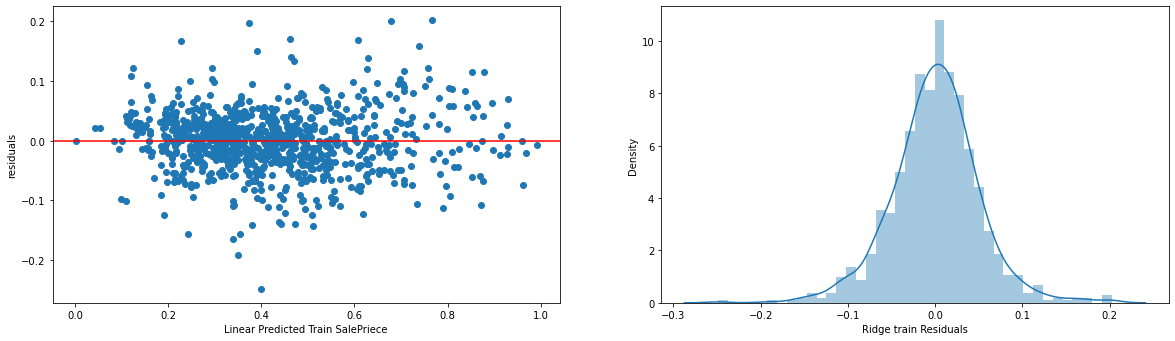

<Figure size 432x288 with 0 Axes>

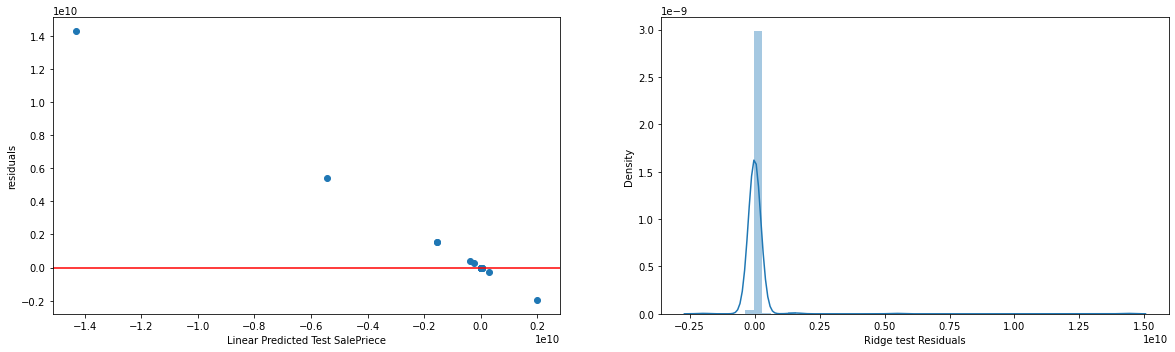

In [9]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
y_lr_res_train = y_train - y_train_pred
df_train['y_lr_res_train'] = y_lr_res_train
df_train['y_train_pred'] = y_train_pred
plt.scatter(df_train.y_train_pred, df_train.y_lr_res_train)
plt.axhline(y=0, color='red')
plt.xlabel("Linear Predicted Train SalePriece")
plt.ylabel("residuals")

plt.subplot(2,2,2)
p = sns.distplot(df_train['y_lr_res_train'])
plt.xlabel("Ridge train Residuals")

# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize=(20, 12))
plt.subplot(2,2,3)
y_lr_res_test = y_test - y_test_pred
df_test['y_lr_res_test'] = y_lr_res_test
df_test['y_test_pred'] = y_test_pred
plt.scatter(df_test.y_test_pred, df_test.y_lr_res_test)
plt.axhline(y=0, color='red')
plt.xlabel("Linear Predicted Test SalePriece")
plt.ylabel("residuals")

plt.subplot(2,2,4)
p = sns.distplot(df_test['y_lr_res_test'])
plt.xlabel("Ridge test Residuals")

plt.show()

<Figure size 432x288 with 0 Axes>

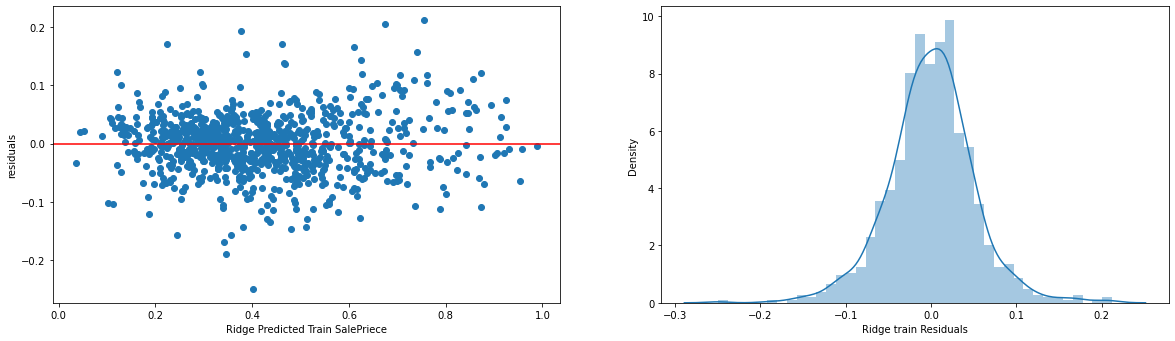

<Figure size 432x288 with 0 Axes>

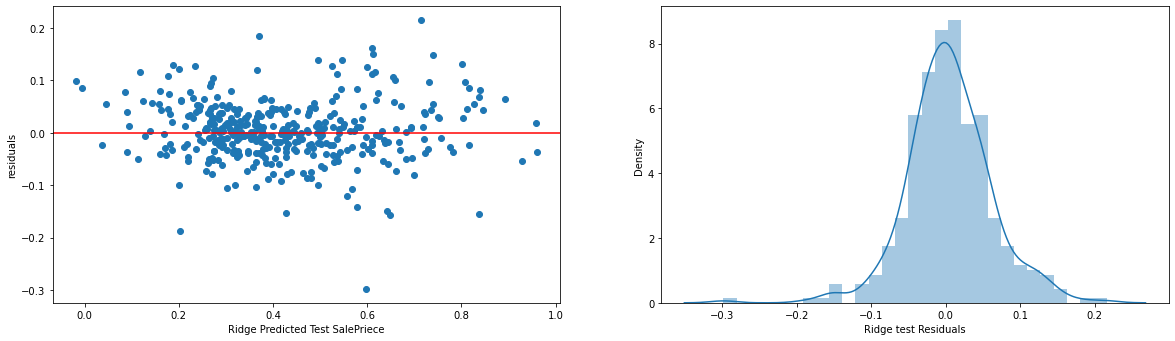

In [10]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
y_ridge_res_train = y_train - y_pred_train_ridge
df_train['y_ridge_res_train'] = y_ridge_res_train
df_train['y_pred_train_ridge'] = y_pred_train_ridge
plt.scatter(df_train.y_pred_train_ridge, df_train.y_ridge_res_train)
plt.axhline(y=0, color='red')
plt.xlabel("Ridge Predicted Train SalePriece")
plt.ylabel("residuals")

plt.subplot(2,2,2)
p = sns.distplot(df_train['y_ridge_res_train'])
plt.xlabel("Ridge train Residuals")

# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize=(20, 12))
plt.subplot(2,2,3)
y_ridge_res_test = y_test - y_pred_test_ridge
df_test['y_ridge_res_test'] = y_ridge_res_test
df_test['y_pred_test_ridge'] = y_pred_test_ridge
plt.scatter(df_test.y_pred_test_ridge, df_test.y_ridge_res_test)
plt.axhline(y=0, color='red')
plt.xlabel("Ridge Predicted Test SalePriece")
plt.ylabel("residuals")

plt.subplot(2,2,4)
p = sns.distplot(df_test['y_ridge_res_test'])
plt.xlabel("Ridge test Residuals")

plt.show()


plt.show()


<Figure size 432x288 with 0 Axes>

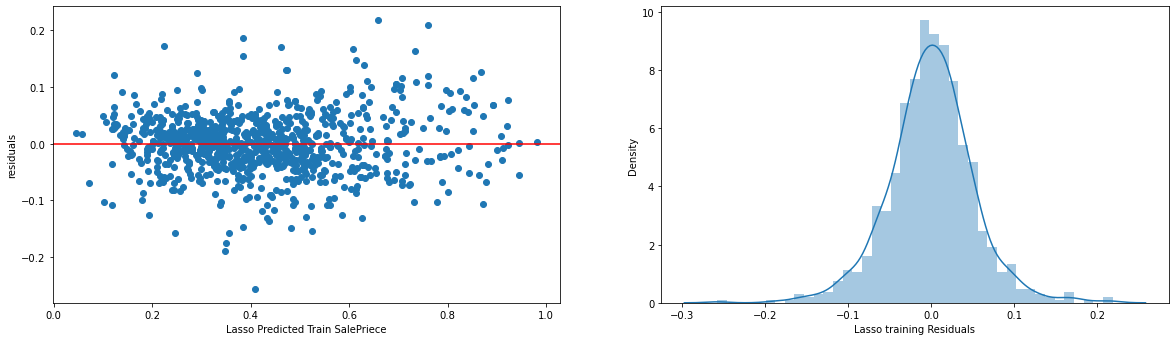

<Figure size 432x288 with 0 Axes>

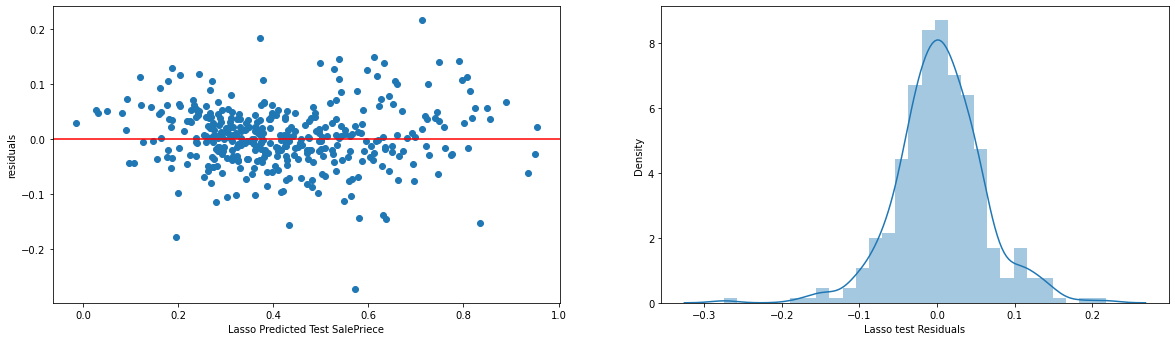

In [11]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
y_lasso_res_train = y_train - y_pred_train_lasso
df_train['y_lasso_res_train'] = y_lasso_res_train
df_train['y_pred_train_lasso'] = y_pred_train_lasso
plt.scatter(df_train.y_pred_train_lasso, df_train.y_lasso_res_train)
plt.axhline(y=0, color='red')
plt.xlabel("Lasso Predicted Train SalePriece")
plt.ylabel("residuals")

plt.subplot(2,2,2)
p = sns.distplot(df_train['y_lasso_res_train'])
plt.xlabel("Lasso training Residuals")

# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize=(20, 12))
plt.subplot(2,2,3)
y_lasso_res_test = y_test - y_pred_test_lasso
df_test['y_lasso_res_test'] = y_lasso_res_test
df_test['y_pred_test_lasso'] = y_pred_test_lasso
plt.scatter(df_test.y_pred_test_lasso, df_test.y_lasso_res_test)
plt.axhline(y=0, color='red')
plt.xlabel("Lasso Predicted Test SalePriece")
plt.ylabel("residuals")

plt.subplot(2,2,4)
p = sns.distplot(df_test['y_lasso_res_test'])
plt.xlabel("Lasso test Residuals")

plt.show()

plt.show()

### Actual and Predicted response variable for Train and Test dataset

<Figure size 432x288 with 0 Axes>

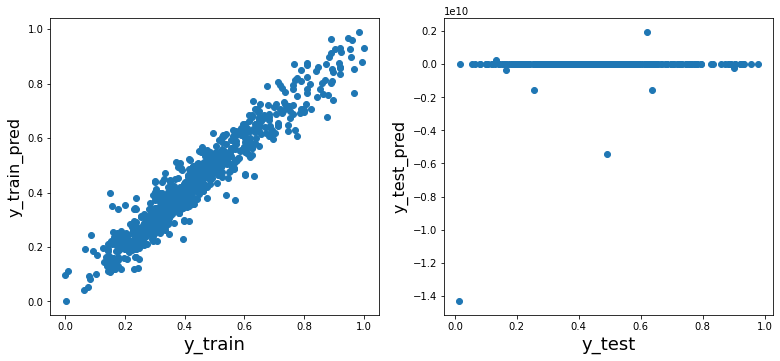

In [12]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
plt.scatter(y_train, y_train_pred)
fig.suptitle('y_train vs y_train_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_train', fontsize=18)                          # X-label
plt.ylabel('y_train_pred', fontsize=16)  

plt.subplot(2,3,2)
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_test_pred', fontsize=16)  

plt.show()

<Figure size 432x288 with 0 Axes>

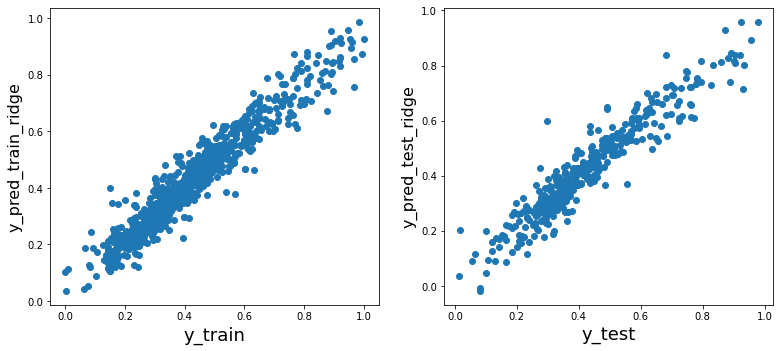

In [13]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
plt.scatter(y_train, y_pred_train_ridge)
fig.suptitle('y_train vs y_pred_train_ridge', fontsize=20)              # Plot heading 
plt.xlabel('y_train', fontsize=18)                          # X-label
plt.ylabel('y_pred_train_ridge', fontsize=16)  

plt.subplot(2,3,2)
plt.scatter(y_test, y_pred_test_ridge)
fig.suptitle('y_test vs y_pred_test_ridge', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred_test_ridge', fontsize=16)  

plt.show()

<Figure size 432x288 with 0 Axes>

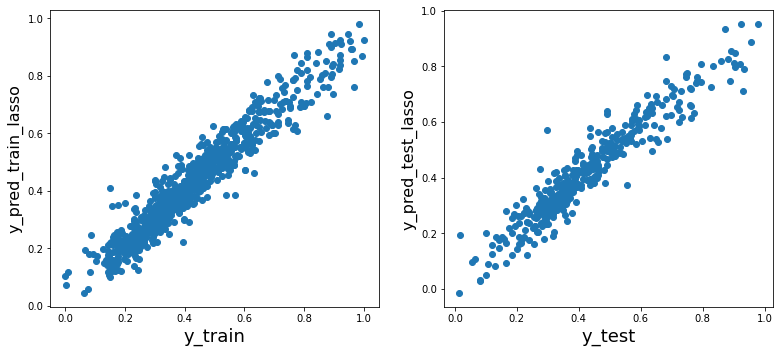

In [14]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
plt.scatter(y_train, y_pred_train_lasso)
fig.suptitle('y_train vs y_pred_train_lasso', fontsize=20)              # Plot heading 
plt.xlabel('y_train', fontsize=18)                          # X-label
plt.ylabel('y_pred_train_lasso', fontsize=16)  

plt.subplot(2,3,2)
plt.scatter(y_test, y_pred_test_lasso)
fig.suptitle('y_test vs y_pred_test_lasso', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred_test_lasso', fontsize=16)  

plt.show()